<a href="https://colab.research.google.com/github/crew-guy/ml-with-tensorflow/blob/main/tf_cnn_cvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to CNNs & CVI

![Image 1](https://testbucket1841.s3.ap-south-1.amazonaws.com/tf-ml-course-udemy/cnn-archi.png)
![Image 2](https://testbucket1841.s3.ap-south-1.amazonaws.com/tf-ml-course-udemy/cnn-archi-2.png)



Computer vision is the practice of devising algorithms that can discover patterns in visual data. Eg: camera of a self-driving car recognizing the car in the front

## Get the data

The images we're working with, are from the Food101 dataset (101 different classes of food): [Link](https://www.kaggle.com/datasets/dansbecker/food-101)

However, we've modified it to only use 2 classes (pizza 🍕 & steak 🥩 ) using the image data modification notebook - [Link](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)

> 🔑 **Note:** We start out with a small dataset to figure out, what works (or better yet, what doesn't work, before scaling up)

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-11-25 14:29:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  23.9MB/s    in 5.6s    

2022-11-25 14:29:56 (18.8 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Becoming one with the data

For any ML problem it is important to understand the data, before we can learning

For a computer vision problem, this involves visualizing many samples of the data

🔴 Important steps to follow for warming up with the data:
1. Turn all your images into numbers (neural networks can't work with images)
2. Make sure that all of your tensors have the right shape
3. Standardize/Normalize your data (neural networks prefer that data is normalized)

In [3]:
!ls pizza_steak

test  train


In [4]:
import os

# Walk thorugh pizza_steak directory & list number of files
for dirpath,dirnames,filenames in os.walk('pizza_steak'):
    print(f"There are {len(dirnames)} directories & {len(filenames)} files in dirpath: '{dirpath}'.")

There are 2 directories & 0 files in dirpath: 'pizza_steak'.
There are 2 directories & 0 files in dirpath: 'pizza_steak/train'.
There are 0 directories & 750 files in dirpath: 'pizza_steak/train/steak'.
There are 0 directories & 750 files in dirpath: 'pizza_steak/train/pizza'.
There are 2 directories & 0 files in dirpath: 'pizza_steak/test'.
There are 0 directories & 250 files in dirpath: 'pizza_steak/test/steak'.
There are 0 directories & 250 files in dirpath: 'pizza_steak/test/pizza'.


In [5]:
# Another way to find out how many images are in a folder

num_steak_images_train = len(os.listdir('pizza_steak/train/steak'))

num_steak_images_train

750

To visualize our images, first let's get the class names programmatically

In [6]:
# Get class names programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path('pizza_steak/train')
classnames = np.array(sorted([item.name for item in data_dir.glob("*")]))
classnames

array(['pizza', 'steak'], dtype='<U5')

In [7]:
# Viewing a random image
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir, target_class):
    target_folder= target_dir + target_class

    # Sample a random image
    random_image = random.sample(os.listdir(target_folder), 1)

    # Showing the image with label
    image = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(image)
    plt.title(target_class)
    plt.show()
    return image

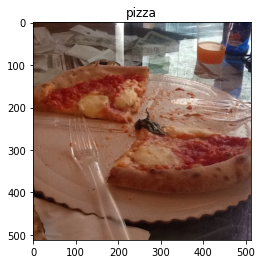

In [8]:
img = view_random_image(
    target_dir = "pizza_steak/train/",
    target_class = "pizza"
)

In [9]:
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 59,  29,  18],
        [ 60,  30,  19],
        [ 60,  30,  19],
        ...,
        [ 34,  44,  80],
        [ 38,  48,  84],
        [ 41,  51,  87]],

       [[ 60,  30,  19],
        [ 61,  31,  20],
        [ 61,  31,  20],
        ...,
        [ 36,  46,  81],
        [ 41,  51,  87],
        [ 43,  53,  89]],

       [[ 60,  30,  19],
        [ 60,  30,  19],
        [ 61,  31,  20],
        ...,
        [ 39,  47,  83],
        [ 42,  52,  87],
        [ 45,  55,  90]],

       ...,

       [[109,  68,  40],
        [109,  68,  40],
        [107,  66,  38],
        ...,
        [ 93,  81,  93],
        [100,  88, 100],
        [ 93,  81,  93]],

       [[106,  65,  37],
        [106,  65,  37],
        [105,  64,  36],
        ...,
        [ 95,  83,  95],
        [ 99,  87,  99],
        [ 92,  80,  92]],

       [[106,  65,  37],
        [105,  64,  36],
        [104,  63,  35],
        ...,
        [ 96,  84,  9

In [10]:
# View image shape
img.shape # Returns width, height, colour channels

(512, 512, 3)

In [11]:
# Get all the pixel values between 0 & 1
img/255

array([[[0.23137255, 0.11372549, 0.07058824],
        [0.23529412, 0.11764706, 0.0745098 ],
        [0.23529412, 0.11764706, 0.0745098 ],
        ...,
        [0.13333333, 0.17254902, 0.31372549],
        [0.14901961, 0.18823529, 0.32941176],
        [0.16078431, 0.2       , 0.34117647]],

       [[0.23529412, 0.11764706, 0.0745098 ],
        [0.23921569, 0.12156863, 0.07843137],
        [0.23921569, 0.12156863, 0.07843137],
        ...,
        [0.14117647, 0.18039216, 0.31764706],
        [0.16078431, 0.2       , 0.34117647],
        [0.16862745, 0.20784314, 0.34901961]],

       [[0.23529412, 0.11764706, 0.0745098 ],
        [0.23529412, 0.11764706, 0.0745098 ],
        [0.23921569, 0.12156863, 0.07843137],
        ...,
        [0.15294118, 0.18431373, 0.3254902 ],
        [0.16470588, 0.20392157, 0.34117647],
        [0.17647059, 0.21568627, 0.35294118]],

       ...,

       [[0.42745098, 0.26666667, 0.15686275],
        [0.42745098, 0.26666667, 0.15686275],
        [0.41960784, 0

## Building an end to end CNN model


Let's build a convolutional neural network to find patterns in our images.
More specifically we need a way to:


* Load our images
* Pre-process our images
* Build a CNN to find patterns in our images
* Compile our CNN model
* Fit the CNN to our training data

In [ ]:
# Set the seed
tf.random.set_seed(42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)

# Generate batches of tensor image data with real-time data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to data directories
train_dir = "/content/pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories & turn it into batches
# flow_from_directory - Takes the path to a directory & generates batches of augmented data.
train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode="binary",
    seed=42
)
valid_data  = test_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=32,
    target_size=(224,224),
    class_mode="binary",
    seed=42
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# Build our own CNN model (Same as Tiny VGG on the CNN explainer website)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        activation="relu",
        input_shape=(224,224,3)
    ),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compiling our model
model_1.compile(
    loss="binary_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

# Train our model
# The flow_from_directory function from above, creates data & labels (X & y) automatically for us and 
# hence we don't have to pass them both separately to our model for training. They're both included in the train_data itself
history_1 = model_1.fit(
    train_data,
    epochs =5,
    # We have 1500 training images in total. train_data has len(train_data) batches of 32 images (& their labels) each 
    # (len(train_data) = 1500/32)
    #  Train the images in batches since our computer memory can't fit all images at once
    # Thus we find patterns from images, in batches
    steps_per_epoch = len(train_data),
    validation_data = valid_data,
    validation_steps =len(valid_data)
)


NameError: ignored

> 🔑 **Note** - If the cell is taking longer than 10 seconds per epoch make sure you're using a GPU by going to Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU (might have to rerun all the cells)

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

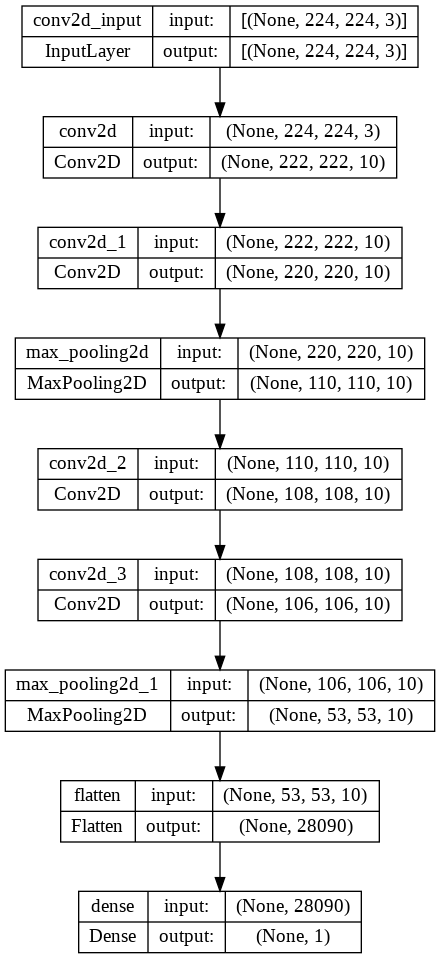

In [ ]:
tf.keras.utils.plot_model(model=model_1,show_shapes=True)

## Use the same model as before


Let's replicate this model built in TensorFlow playground to understand if it works with image data - [Link](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.96138&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

In [ ]:
# Set a random seed
tf.random.set_seed(42)

# 1. Create a model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])


# 2. Compile a model
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)


# 3. Train the model
history_2 = model_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 1/5
47/47 [==============================] - 12s 243ms/step - loss: 0.7341 - accuracy: 0.4920 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 11s 235ms/step - loss: 0.6966 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5000


KeyboardInterrupt: ignored

In [ ]:
# Summary of model_2
model_2.summary()

Despite having 20x more parameters than our CNN (model_1), model_2 performs terribly, let's try to improve it

In [ ]:
# Training a model with more layers

# Set random seed 
tf.random.set_seed(42)

# 1. Create a model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

# 2. Compile a model
model_3.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer="Adam",
    metrics=["accuracy"]
)

# 3. Train a model
model_3.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

In [ ]:
# But this is still too many parameters
model_3.summary()

> 🔑 **Note**: We can think of learnable parameters as patterns in data that we can learn. While more is better in a lot of cases, sometimes sorting out & learning the most important parameters plays a much more significant role. So even though there are less learnable parameters in our CNN, because it learns the most import pattern in our data, these parameters are often more helpful to deciphering between different features in an image 

## Binary classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize)
2. Preprocess your data (normalize/standardize the values)
3. Create the model (Start with a baseline eg: a research paper)
4. Compile it & fit the model
5. Evaluate it
6. Tune hyperparameters to improve model performance (try to beat the baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

### 1. Become one with the data

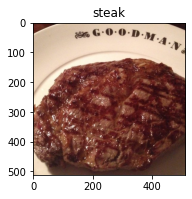

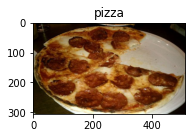

In [12]:
# Visualize the data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image('pizza_steak/train/','steak')
plt.subplot(1,2,2)
steak_img = view_random_image('pizza_steak/train/','pizza')

### 2. Preprocess the data (Prepare it for a model)

In [13]:
# Define directory dataset paths
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'

Let's divide our data into **batches**

📖 A batch is a subset of the dataset that our model looks at while training

Rather than looking at all images at a time (1500, in this case), a model only looks at subset of them (32, in this case)

It does this for a couple of reasons:
1. 10000 images (or more) might not fit into the memory of your processor (GPU)
2. Trying to learn the patterns in all images in one hit could result in the model not being to learn very well


Why 32 ? Because it's bad for the test error - [Reference](https://twitter.com/ylecun/status/989610208497360896)

In [14]:
# Create train & test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# ImageDataGenerator takes in images (JPG, PNG etc.) in batches and turns them into tensor image data
# Also, we can apply transformations on this tensor image data, such as rescale, that allows us to element-wise multiply the image tensor with a constant
# We use the "." in "1/255." to simultaneously convert the value into a float
train_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

In [15]:
# Load in the image data from directory & turn them into batches
train_data = train_data_gen.flow_from_directory(
    directory=train_dir,
    # Tuple of integers that specify the height, width
    target_size=(224,224),
    class_mode='binary',
    batch_size=32
)
test_data = test_data_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    class_mode="binary",
    batch_size=32
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [16]:
# Get a sample of train_data batch
images, labels = train_data.next() # Get the "next" batch of images & labels in train_data
len(images), len(labels)

(32, 32)

In [17]:
# Number of batches = total_data/batch_size
len(train_data)

47

In [18]:
# Get 1st 2 images
images[0].shape, images[:2]

((224, 224, 3), array([[[[0.19215688, 0.5411765 , 0.2901961 ],
          [0.18823531, 0.5372549 , 0.2784314 ],
          [0.15686275, 0.49411768, 0.2392157 ],
          ...,
          [0.4039216 , 0.2392157 , 0.04313726],
          [0.43529415, 0.28235295, 0.05882353],
          [0.48627454, 0.3372549 , 0.09411766]],
 
         [[0.14117648, 0.4901961 , 0.2392157 ],
          [0.16862746, 0.5058824 , 0.25882354],
          [0.16862746, 0.5058824 , 0.2509804 ],
          ...,
          [0.37254903, 0.21176472, 0.        ],
          [0.43921572, 0.2901961 , 0.04705883],
          [0.4666667 , 0.31764707, 0.0627451 ]],
 
         [[0.14117648, 0.4784314 , 0.2392157 ],
          [0.18039216, 0.5176471 , 0.2784314 ],
          [0.1764706 , 0.5137255 , 0.26666668],
          ...,
          [0.54901963, 0.3921569 , 0.14901961],
          [0.6       , 0.454902  , 0.18823531],
          [0.57254905, 0.427451  , 0.15294118]],
 
         ...,
 
         [[0.37254903, 0.        , 0.01568628],
   

In [19]:
images[7].shape

(224, 224, 3)

In [20]:
# View the first batch of labels
labels

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

### 3. Create a baseline CNN model

A "baseline" is a relatively simple & existing result that you setup when you're setting up a ML experiment & as you keep experimenting, you try to beat the baseline

> 🔑 **Note**: In deep learning, there is an infinite number of architectures that can be potentially created so you can just start with a simple architecture, make it work & then start adding complexities via researching on which current model is performing best in the field for your problem

📖 Explore State of the Art algorithms here - [Link](https://paperswithcode.com/sota)

In [21]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential


model_4 = Sequential([
    Conv2D(
        filters=10,
        kernel_size=32,
        padding="valid", # if "same", output gets compressed, else, output shape is >= input shape
        strides=1,
        input_shape =(224,224,3) # Input layer (specify input shape)
    ),
    # By default, padding is always valid & strides is 1
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid"), # Output layer (binary classification so only 1 output neuron)
])

model_4.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

Understanding what's inside a conv 2d layer

![image](https://testbucket1841.s3.ap-south-1.amazonaws.com/tf-ml-course-udemy/conv-2d.png)

### 4. Fit the model

In [22]:
# Check the lengths of training & test data
len(train_data), len(test_data)

(47, 16)

In [23]:
# Fit the data
history_4 = model_4.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=5,
    validation_data = test_data,
    validation_steps = len(test_data)
)

Epoch 1/5
47/47 [==============================] - 30s 337ms/step - loss: 1.0108 - accuracy: 0.5080 - val_loss: 0.6668 - val_accuracy: 0.6100
Epoch 2/5
47/47 [==============================] - 9s 193ms/step - loss: 0.6857 - accuracy: 0.5193 - val_loss: 0.6947 - val_accuracy: 0.5060
Epoch 3/5
47/47 [==============================] - 9s 197ms/step - loss: 0.6920 - accuracy: 0.4980 - val_loss: 0.6948 - val_accuracy: 0.5040
Epoch 4/5
47/47 [==============================] - 9s 196ms/step - loss: 0.6918 - accuracy: 0.5000 - val_loss: 0.6949 - val_accuracy: 0.5100
Epoch 5/5
47/47 [==============================] - 9s 198ms/step - loss: 0.7057 - accuracy: 0.5220 - val_loss: 0.6935 - val_accuracy: 0.5020


### 5. Evaluating our model

It looks like our model learnt something, let's evaluate it

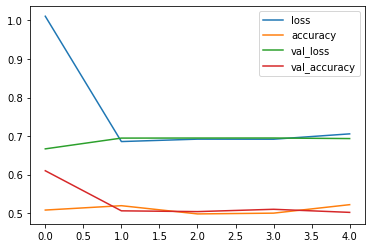

In [24]:
import pandas as pd
pd.DataFrame(history_4.history).plot()

In [25]:
# Create a function for visualizing evaluation metrics separately

def plot_learning_curves(history):
  """
    Takes in a model's training history & returns all the learning curves to evaluate the model's performance
  """

  # Evaluation metrics
  loss= history.history["loss"]
  val_loss= history.history["val_loss"]
  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  # Plot the loss curves
  plt.figure(figsize=(7,9))
  plt.plot(epochs,loss, label='loss')
  plt.plot(epochs,val_loss, label='val_loss')
  plt.title('loss curves')
  plt.xlabel('epochs')


  # Plot the accuracy curves
  plt.figure()
  plt.plot(epochs, accuracy, label="accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title('accuracy curves')
  plt.xlabel('epochs')

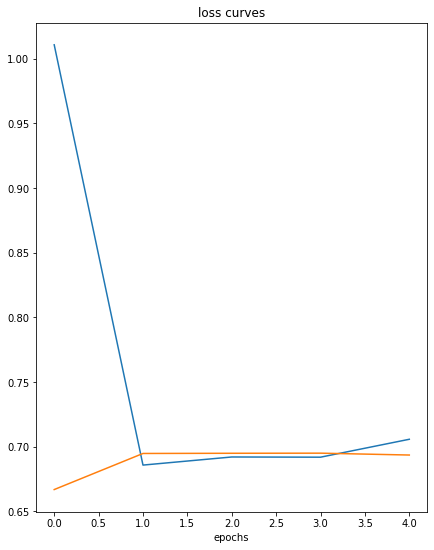

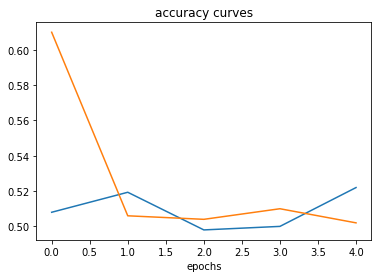

In [26]:
plot_learning_curves(history_4)

🔑 **Note**: If the val_loss is increasing with number of epochs, it means that the model is **overfitting** the dataset. The patterns are being fitted too well on the *training_data* and hence the performance in a more generalized environment is diminished

### 6. Adjust model parameters

Fitting a ML model comes in 3 steps

1. Create a baseline
2. Beat the baseline by overfitting a large model
3. Reduce overfitting


Ways to induce overfitting:

* Increase number of conv layers
* Increase number of conv filters
* Add another dense layer to our output of flattened layer


Ways to reduce overfitting
* Add data augmentation
* Add more regularization layers (such as MaxPool2D)
* Add more data...


🔑 **Note**: Reducing overfitting is aka "regularization"

In [27]:
# While a convolution find the features of an image, max pooling finds the most important parts of an image
model_5 = Sequential([
    Conv2D(filters=10, kernel_size=(3,3), strides=(1,1), input_shape=(224,224,3)),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2,padding="valid"),
    Conv2D(10,3, activation="relu"),
    MaxPool2D(),
    Conv2D(10,3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_5.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"]
)

history_5 = model_5.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data)
)


Epoch 1/5
47/47 [==============================] - 11s 213ms/step - loss: 0.6556 - accuracy: 0.5973 - val_loss: 0.5135 - val_accuracy: 0.7620
Epoch 2/5
47/47 [==============================] - 9s 193ms/step - loss: 0.5498 - accuracy: 0.7253 - val_loss: 0.4371 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 9s 196ms/step - loss: 0.4674 - accuracy: 0.7920 - val_loss: 0.3878 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 9s 197ms/step - loss: 0.4208 - accuracy: 0.8133 - val_loss: 0.4246 - val_accuracy: 0.7980
Epoch 5/5
47/47 [==============================] - 9s 194ms/step - loss: 0.3936 - accuracy: 0.8307 - val_loss: 0.3805 - val_accuracy: 0.8340


In [28]:
model_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_5 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 10)     0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 107, 107, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [4]:
# Plot loss curves
plot_learning_curves(history_5)

NameError: ignored

In [3]:
#### Opening our bag of tricks & finding data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1)

NameError: ignored